In [1]:
# | default_exp glssm

In [2]:
# | export
import jax.numpy as jnp
import jax.random as jrn
from jax import vmap
from jax.lax import scan
from jaxtyping import Array, Float, PRNGKeyArray

from isssm.kalman import kalman
from isssm.typing import GLSSM, GLSSMObservationModel, GLSSMState, Observations, States
from isssm.util import MVN_degenerate as MVN, mm_sim

In [3]:
# | hide
# use x86 for testing purposes
import jax
import matplotlib.pyplot as plt
from isssm.kalman import kalman, smoother
import fastcore.test as fct

In [4]:
# use x86 for testing purposes
jax.config.update("jax_enable_x64", True)

# Gaussian Linear State Space Models
> Simulation and components, see also [the corresponding chapter in my thesis](https://stefanheyder.github.io/dissertation/thesis.pdf#nameddest=section.3.2).

Consider a Gaussian state space model of the form
$$
\begin{align*}
    X_0 &\sim \mathcal N (u_{0}, \Sigma_0) &\\
    X_{t + 1} &= u_{t + 1}  + A_t X_{t} + D_{t}\varepsilon_{t + 1} &t = 0, \dots, n - 1\\
    \varepsilon_t &\sim \mathcal N (0, \Sigma_t) & t = 1, \dots, n \\
    Y_t &= v_{t} + B_t X_t + \eta_t & t =0, \dots, n & \\
    \eta_t &\sim \mathcal N(0, \Omega_t) & t=0, \dots, n.
\end{align*}
$$
As the joint distribution of $(X_0, \dots, X_n, Y_0, \dots, Y_n)$ is Gaussian, we call it a **G**aussian **l**inear  **s**tate **s**pace **m**odel (GLSSM).

The dimensions of the components are as follows:
$$
    \begin{align*}
    u_{t}, X_{t} &\in \mathbf R^{m} \\
    \varepsilon_{t} &\in \mathbf R^{l} \\
    v_{t}, Y_{t}, \eta_{t} &\in \mathbf R^{p}
    \end{align*}
$$
and 
$$
    \begin{align*}
    A_{t} &\in \mathbf R^{m\times m} \\
    D_{t} &\in \mathbf R^{m \times l} \\
    \Sigma_{0} &\in \mathbf R^{m \times m} \\
    \Sigma_{t} &\in \mathbf R^{l \times l}\\
    B_{t} &\in \mathbf R^{p \times m} \\
    \Omega_{t} &\in\mathbf R^{p \times p} 
    \end{align*}
$$
and we assume that $D_t$ is a submatrix of the identity matrix, such that $D_t^T D_t = I_{l}$.




## Sampling from the joint distribution
To obtain a sample $(X_0, \dots, X_n), (Y_0, \dots, Y_n)$ we first simulate from the joint distribution of the states and then, as observations are coniditionally independent of one another given the states, simulate all states at once.

In [5]:
# | export


def simulate_states(
    state: GLSSMState,
    N: int,  # number of samples to draw
    key: PRNGKeyArray,  # the random state
) -> Float[Array, "N n+1 m"]:  # array of N samples from the state distribution
    """Simulate states of a GLSSM"""
    u, A, D, Sigma0, Sigma = state

    _, _, l = D.shape

    def sim_next_states(carry, inputs):
        x_prev, key = carry
        u, A, D, Sigma = inputs

        key, subkey = jrn.split(key)
        eps = MVN(jnp.zeros(l), Sigma).sample(N, seed=subkey)

        samples = u + mm_sim(A, x_prev) + mm_sim(D, eps)

        return (samples, key), samples

    key, subkey = jrn.split(key)
    x0 = MVN(u[0], Sigma0).sample(N, subkey)
    key, subkey = jrn.split(key)
    init = (x0, subkey)

    _, X = scan(sim_next_states, init, (u[1:], A, D, Sigma))

    X = jnp.concatenate([x0[None], X], axis=0)

    return X.transpose((1, 0, 2))

In [6]:
# | export

from isssm.typing import to_states, to_observation_model


def simulate_glssm(
    glssm: GLSSM,
    N: int,  # number of sample paths
    key: PRNGKeyArray,  # the random state
) -> (
    Float[Array, "N n+1 m"],
    Float[Array, "N n+1 p"],
):  # tuple of two arrays each with of N samples from the state/observation distribution
    """Simulate states and observations of a GLSSM"""

    v, B, Omega = to_observation_model(glssm)
    key, subkey = jrn.split(key)
    X = simulate_states(to_states(glssm), N, subkey).transpose((1, 0, 2))

    S = v[:, None, :] + vmap(mm_sim, (0, 0))(B, X)

    # samples x time x space
    X = X.transpose((1, 0, 2))

    S = S.transpose((1, 0, 2))

    key, subkey = jrn.split(key)
    Y = MVN(S, Omega).sample(seed=subkey)

    return X, Y

In [7]:
from isssm.models.stsm import stsm

As a toy example, we consider a structural time series model with trend and velocity, as well as a seasonal component of order 2, see [here](models/10_stsm.ipynb) for details.
The following code creates the model and simulates once from its joint distribution.

In [8]:
model = stsm(jnp.zeros(2 + 2), 0.0, 0.01, 1.0, 100, jnp.eye(2 + 2), 1.0, 2)

key = jrn.PRNGKey(53412312)
key, subkey = jrn.split(key)
(X,), (Y,) = simulate_glssm(model, 1, subkey)

In [9]:
# | hide
np1, p, m = model.B.shape
fct.test_eq(X.shape, (np1, m))
fct.test_eq(Y.shape, (np1, p))

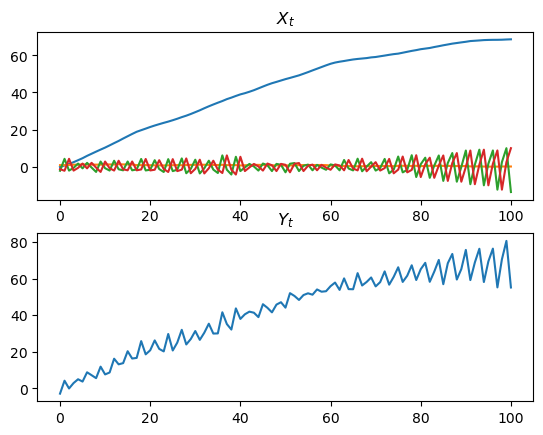

In [10]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.set_title("$X_t$")
ax1.plot(X)

ax2.set_title("$Y_t$")
ax2.plot(Y)
plt.show()

In this figure, we see that the trend varies smoothly, while the seasonal component is visible in the observations $Y_t$.

## Joint Density

By the dependency structure of the model, the joint density factorizes as 

$$
p(x,y) = \prod_{t = 0}^n p(x_{t}| x_{t -1}) p(y_{t}|x_{t})
$$
where $p(x_0|x_{-1}) = p(x_0)$. The following functions return these components or evaluate the joint density directly.

In [11]:
# | export

from isssm.util import mm_time, append_to_front


def log_probs_x(
    x: States, state: GLSSMState  # the states  # the state model
) -> Float[Array, "n+1"]:  # log probabilities $\log p(x_t \vert x_{t-1})$
    """log probabilities $\\log p(x_t | x_{t-1})$"""
    u, A, D, Sigma0, Sigma = state
    _, _, l = D.shape
    log_p0 = MVN(u[0], Sigma0).log_prob(x[0])
    x_prev = x[:-1]

    DT = D.transpose((0, 2, 1))

    eps = mm_time(
        DT, x[1:] - u[1:] - (A @ x_prev[:, :, None])[:, :, 0]
    )

    log_p = MVN(jnp.zeros(l), Sigma).log_prob(eps)
    return append_to_front(log_p0, log_p)


def log_probs_y(
    y: Observations,  # the observations
    x: States,  # the states
    obs_model: GLSSMObservationModel,  # the observation model
) -> Float[Array, "n+1"]:  # log probabilities $\log p(y_t \vert x_t)$
    """log probabilities $\\log p(y_t | x_t)$"""
    v, B, Omega = obs_model
    y_pred = v + (B @ x[:, :, None])[:, :, 0]
    return MVN(y_pred, Omega).log_prob(y)


def log_prob(x: States, y: Observations, glssm: GLSSM) -> Float:  # $\log p(x,y)$
    """joint log probability of states and observations"""
    log_p_x = jnp.sum(log_probs_x(x, to_states(glssm)))
    log_p_y_given_x = jnp.sum(log_probs_y(y, x, to_observation_model(glssm)))
    return log_p_x + log_p_y_given_x

In [12]:
fct.test_eq(log_probs_x(X, to_states(model)).shape, (np1,))
fct.test_eq(log_probs_y(Y, X, to_observation_model(model)).shape, (np1,))
fct.test_eq(log_prob(X, Y, model).shape, ())

In [13]:
# | hide
import nbdev

nbdev.nbdev_export()